<a href="https://colab.research.google.com/github/shashwat9kumar/ML-And-DataScience/blob/master/Tensorflow/06_Transfer_Learning_in_Tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with tensorflow part 3: Scaling up

We've seen the power of feature extraction and fine tuning, now it's time to scale up to all of the classes in Food101

Our baseline to beat is 50.76% : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf



In [1]:
!nvidia-smi

Mon Jul  5 10:30:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In the previous notebook we've created series of helper functions to do different set of tasks. let's download them

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-05 10:30:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-05 10:30:09 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebooks

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Visison : Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so lets download it



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2021-07-05 10:30:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   169MB/s    in 8.4s    

2021-07-05 10:30:20 (185 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images calsses are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in

In [6]:
# Set up data inputs

import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with Transfer learning on 10% of 101 food classes

Here are the steps we're going to take

* Create a model checkpoint callback
* Create a data Augmentation layer to build data augmentation raight insto the layer
* Build a headless (no top layer) functional EfficientNetB0 backboned-model(we'll create our own output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the data to save epoch time)

In [7]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_callback"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Cerate a data Augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data Augmentation
data_augmentation = Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2),
     preprocessing.RandomZoom(0.2),
    #  preprocessing.Rescaling(1/255.) # rescale for other models 
    ], name="data_augmentation"
)

In [9]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) #augment images (this happens only during training phase)
x = base_model(x, training=False) #Put the base model in inference mode, and so weights ehich remains frozen, remains frozen
x = layers.GlobalAveragePooling2D(name="global_average_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_layer (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
# Compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)), # validate on 15 percent of test data
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 121s 365ms/step - loss: 3.4730 - accuracy: 0.2533 - val_loss: 2.6258 - val_accuracy: 0.4216
Epoch 2/5
237/237 [==============================] - 72s 304ms/step - loss: 2.3518 - accuracy: 0.4569 - val_loss: 2.2436 - val_accuracy: 0.4703
Epoch 3/5
237/237 [==============================] - 65s 271ms/step - loss: 1.9824 - accuracy: 0.5271 - val_loss: 2.0587 - val_accuracy: 0.4873
Epoch 4/5
237/237 [==============================] - 61s 255ms/step - loss: 1.7604 - accuracy: 0.5747 - val_loss: 1.9949 - val_accuracy: 0.4968
Epoch 5/5
237/237 [==============================] - 59s 247ms/step - loss: 1.6053 - accuracy: 0.6066 - val_loss: 1.9405 - val_accuracy: 0.5016


In [12]:
  # Evaluate on the whole test dataset
  fine_tune_results = model.evaluate(test_data)
  fine_tune_results

790/790 [==============================] - 88s 111ms/step - loss: 1.7194 - accuracy: 0.5504


[1.7194173336029053, 0.5503762364387512]

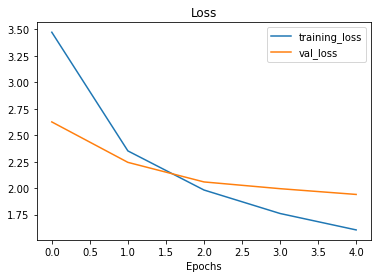

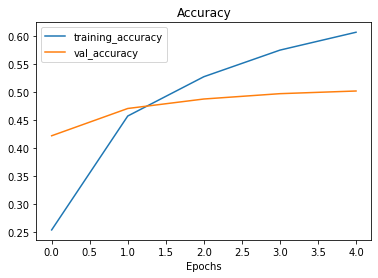

In [13]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** What do these curves suggest? Hint: These two curves shoud be very similar, if not then???

It suggests that our model may be overfitting.

## Fine tunung

In [22]:
# Unfreeze all of the layers in the base model

base_model.trainable=True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [23]:
# Recompile with a lower learning rate (it's best practice to lower learning rate)
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"]) # learning rate lowered by 10x

In [24]:
# What layers in the  model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pool_layer True
output_layer True


In [25]:
# Check which lauers are trainalbe in base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [26]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10 # the model has already trained for 5 epochs (this is the total no of epochs) 5 feature extraction, 5 fine tune

histroy_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch=len(train_data_all_10_percent),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 64s 244ms/step - loss: 0.0417 - accuracy: 0.6222 - val_loss: 0.0353 - val_accuracy: 0.4860
Epoch 6/10
237/237 [==============================] - 53s 223ms/step - loss: 0.0268 - accuracy: 0.6446 - val_loss: 0.0329 - val_accuracy: 0.4876
Epoch 7/10
237/237 [==============================] - 52s 218ms/step - loss: 0.0244 - accuracy: 0.6683 - val_loss: 0.0317 - val_accuracy: 0.4907
Epoch 8/10
237/237 [==============================] - 52s 219ms/step - loss: 0.0230 - accuracy: 0.6805 - val_loss: 0.0315 - val_accuracy: 0.4918
Epoch 9/10
237/237 [==============================] - 52s 216ms/step - loss: 0.0217 - accuracy: 0.6976 - val_loss: 0.0313 - val_accuracy: 0.4952
Epoch 10/10
237/237 [==============================] - 49s 207ms/step - loss: 0.0207 - accuracy: 0.7139 - val_loss: 0.0307 - val_accuracy: 0.5056


In [27]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 86s 109ms/step - loss: 0.0272 - accuracy: 0.5695


[0.027154715731739998, 0.5694653391838074]

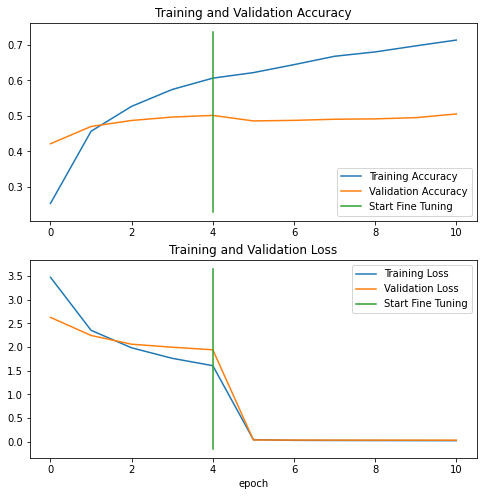

In [28]:
# Compare the histories of feature extraction model with fine tuning history
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=histroy_all_classes_10_percent_fine_tune)

## Saving and loading our model

To use our model in external application we'll need to save it and export it somewhere


In [29]:
model.save("/content/drive/MyDrive/SavedModels/101_food_classes_10_percent_saved_big_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SavedModels/101_food_classes_10_percent_saved_big_dog_model/assets


In [31]:
# load and evaluate the saved the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/SavedModels/101_food_classes_10_percent_saved_big_dog_model")

In [32]:
# Evaluate the loaded model and compare performance to presaved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 88s 110ms/step - loss: 0.0272 - accuracy: 0.5695


[0.027154715731739998, 0.5694653391838074]

In [33]:
all_classes_10_percent_fine_tune_results

[0.027154715731739998, 0.5694653391838074]

# Evaluating the performance of the big dog model across all different classes

Lets make some predictions, visualize them and then later find out which predictions were most wrong

In [34]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-07-05 11:40:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   223MB/s    in 0.2s    

2021-07-05 11:40:48 (223 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [35]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [36]:
# Load in pretrained saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [37]:
# Evaluate loaded model (the one we downloaded just now)
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 91s 113ms/step - loss: 1.8027 - accuracy: 0.6078


In [38]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

## Making prediction with ourtrained model

In [39]:
# Making predictions with our model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how log is left

790/790 [==============================] - 61s 76ms/step


In [40]:
len(test_data)

790

In [41]:
# How many predictions are there?
len(preds_probs)

25250

In [42]:
# Whats the sahape of our predictiosn
preds_probs.shape

(25250, 101)

In [43]:
# Lets see what the first 10 predictions look like
preds_probs[:10]

array([[5.95420077e-02, 3.57419503e-06, 4.13768589e-02, ...,
        1.41386813e-09, 8.35307583e-05, 3.08974274e-03],
       [9.64016676e-01, 1.37532707e-09, 8.47805641e-04, ...,
        5.42872003e-05, 7.83623513e-12, 9.84663906e-10],
       [9.59258676e-01, 3.25335823e-05, 1.48669467e-03, ...,
        7.18913384e-07, 5.43973158e-07, 4.02759651e-05],
       ...,
       [4.73132670e-01, 1.29312355e-07, 1.48055656e-03, ...,
        5.97501639e-04, 6.69690999e-05, 2.34693434e-05],
       [4.45719399e-02, 4.72655188e-07, 1.22585356e-01, ...,
        6.34984963e-06, 7.53185031e-06, 3.67787597e-03],
       [7.24390090e-01, 1.92497107e-09, 5.23109738e-05, ...,
        1.22913450e-03, 1.57926350e-09, 9.63957209e-05]], dtype=float32)

In [46]:
# What does the 1st prediction probability look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0]) # sum should be very close to 1

(array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
        8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
        1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
        2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
        6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
        1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
        8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
        2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
        1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
        1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
        8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
        2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
        3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
        8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
        3.5306231e-05, 3.2489133e-05, 6.7314817e

Our model outputs a prediction probability array (with N classes) for each sample of image in the dataset

In [48]:
# we get 1 prediction probablity per class( in our case we have 101 prediction probabilities )

print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction prediction probability sample looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0:  {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction prediction probability sample looks like:
 [5.9542008e-02 3.5741950e-06 4.1376859e-02 1.0660556e-09 8.1613978e-09
 8.6639664e-09 8.0926822e-07 8.5652499e-07 1.9859017e-05 8.0977776e-07
 3.1727747e-09 9.8673661e-07 2.8532164e-04 7.8049051e-10 7.4230169e-04
 3.8916416e-05 6.4740193e-06 2.4977280e-06 3.7891099e-05 2.0678388e-07
 1.5538422e-05 8.1506943e-07 2.6230446e-06 2.0010630e-07 8.3827456e-07
 5.4215989e-06 3.7390860e-06 1.3150533e-08 2.7761406e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688865e-04 7.6407297e-10 4.0452729e-04
 1.3150634e-08 1.7957379e-06 1.4448218e-06 2.3062859e-02 8.2466784e-07
 8.5365781e-07 1.7138614e-06 7.0525107e-06 1.8402169e-08 2.8553407e-07
 7.9483234e-06 2.0681514e-06 1.8525066e-07 3.3619774e-08 3.1522498e-04
 1.0410913e-05 8.5448539e-07 8.4741873e-01 1.0555415e-05 4.4094671e-07
 3.7404148e-05 3.5306231e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219660e-10 1.0318080e-05 8.57440

In [50]:
test_data.class_names[52]

'gyoza'

In [52]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [54]:
# how many pred classes do we have?
len(pred_classes)

25250

Now we've got prediction arrays of all the model's predictions, we need to compare them to the original dataset

In [55]:
test_data # test data is wrapped in a batch dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [57]:
# To get out test lables we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels are one hot encoded like [0, 0, 0, 1, 0, ...... 0, 0, 0]

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [58]:
# how many labels are there?
len(y_labels)

25250

## Evaluating our model's prections

one way to check that our models prediction array is in the same order as our test lable array is to fins the accuracy score

In [59]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [60]:
# Let's try scikit learns accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)

In [61]:
sklearn_accuracy #the first 6 digits are same, indicating that the test_labels and presulting lables are in the same oreder

0.6077623762376237

In [64]:
# Does this metric come close to our model's evaluate results?
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True